In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect

# Try adding saturation to SSN

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_57764/189980599.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(ri.phi_int_E.x[idxs],1/(1/500+1/(100000*(np.fmax(0,ri.phi_int_E.x[idxs]))**2)),'k--')
/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_57764/189980599.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(ri.phi_int_I.x[idxs],1/(1/500+1/(200000*(np.fmax(0,ri.phi_int_I.x[idxs]))**2)),'k--')


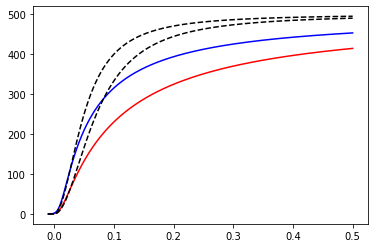

In [454]:
idxs = np.logical_and(ri.phi_int_E.x < 0.5,ri.phi_int_E.x > -0.01)

plt.plot(ri.phi_int_E.x[idxs],ri.phi_int_E.y[idxs],'r')
plt.plot(ri.phi_int_I.x[idxs],ri.phi_int_I.y[idxs],'b')
plt.plot(ri.phi_int_E.x[idxs],1/(1/500+1/(100000*(np.fmax(0,ri.phi_int_E.x[idxs]))**2)),'k--')
plt.plot(ri.phi_int_I.x[idxs],1/(1/500+1/(200000*(np.fmax(0,ri.phi_int_I.x[idxs]))**2)),'k--')

# Approximate Ricciardi Function with Torch Functions

In [164]:
from scipy.special import erf, erfi, expit
from mpmath import fp

def spec_func(x):
    return np.real(x**2*fp.hyp2f2(1.0,1.0,1.5,2.0,x**2))

spec_func_vec = np.vectorize(spec_func, 'D')

In [4]:
import ricciardi as ric

Loading previously saved nonlinearity


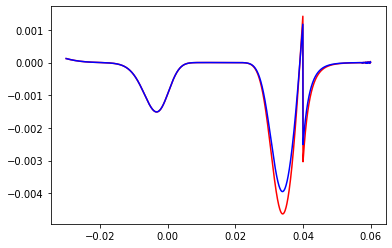

In [615]:
reload(ric)
ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')

idxs = np.logical_and((ri.Vr-ri.phi_int_E.x)/ri.st < 4,(ri.tht-ri.phi_int_E.x)/ri.st > -4)

plt.plot(ri.phi_int_E.x[idxs],1-ri.calc_phi_approx(ri.phi_int_E.x[idxs],ri.tE)/ri.phi_int_E.y[idxs],'r')
plt.plot(ri.phi_int_I.x[idxs],1-ri.calc_phi_approx(ri.phi_int_I.x[idxs],ri.tI)/ri.phi_int_I.y[idxs],'b')
# plt.ylim(0,500)

Loading previously saved nonlinearity


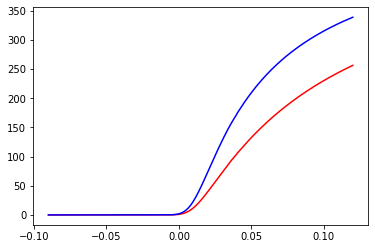

In [612]:
reload(ric)
ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')

idxs = np.logical_and((ri.Vr-ri.phi_int_E.x)/ri.st < 10,(ri.tht-ri.phi_int_E.x)/ri.st > -10)

plt.plot(ri.phi_int_E.x[idxs],ri.calc_phi_approx(ri.phi_int_E.x[idxs],ri.tE),'r')
plt.plot(ri.phi_int_I.x[idxs],ri.calc_phi_approx(ri.phi_int_I.x[idxs],ri.tI),'b')
# plt.ylim(0,500)

Loading previously saved nonlinearity


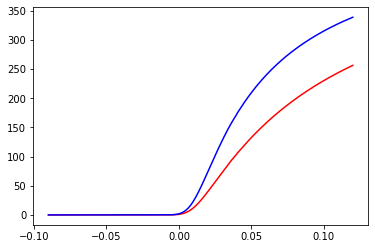

In [611]:
reload(ric)
ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')

idxs = np.logical_and((ri.Vr-ri.phi_int_E.x)/ri.st < 10,(ri.tht-ri.phi_int_E.x)/ri.st > -10)

x_torch = torch.from_numpy(ri.phi_int_E.x[idxs])
y_torch_E = ri.phiE_tensor(x_torch)
y_torch_I = ri.phiI_tensor(x_torch)
plt.plot(x_torch,y_torch_E,'r')
plt.plot(x_torch,y_torch_I,'b')
# plt.ylim(0,500)

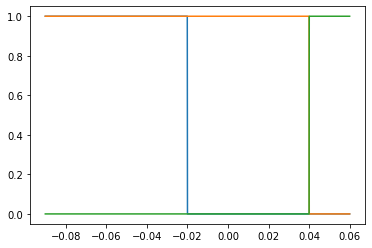

In [541]:
min_u = (ri.Vr-x_torch)/ri.st
max_u = (ri.tht-x_torch)/ri.st

plt.plot(x_torch,min_u> 3)
plt.plot(x_torch,min_u>-3)
plt.plot(x_torch,min_u<-3)

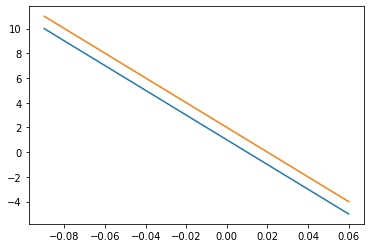

In [593]:
plt.plot(x_torch,min_u)
plt.plot(x_torch,max_u)

# Train Torch NN to Interpolate Ricciardi Transfer Function

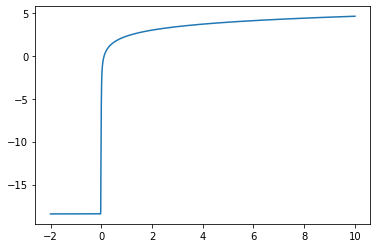

In [83]:
plt.plot(ri.phi_int_E.x[1:-1],-np.log((1 / ((ri.phi_int_E.y[1:-1]/500) + 1e-8)) - 1))

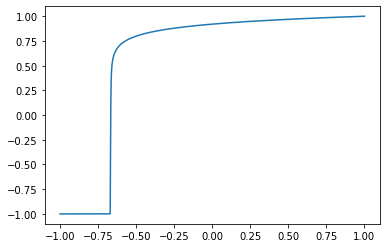

In [81]:
x_all_np = ri.phi_int_E.x[1:-1][:,None]
y_all_np = -np.log((1 / ((ri.phi_int_E.y[1:-1][:,None]/500) + 1e-8)) - 1)

x_sclr = MinMaxScaler(feature_range=(-1, 1))
y_sclr = MinMaxScaler(feature_range=(-1, 1))
x_scld_np = x_sclr.fit_transform(x_all_np)
y_scld_np = y_sclr.fit_transform(y_all_np)
x_scld = torch.from_numpy(x_scld_np).float()
y_scld = torch.from_numpy(y_scld_np).float()
plt.plot(x_scld_np,y_scld_np)

In [24]:
x_train_np,x_test_np,y_train_np,y_test_np = train_test_split(x_scld_np,y_scld_np,shuffle=True,random_state=1234)
x_train = torch.from_numpy(x_train_np).float()
x_test = torch.from_numpy(x_test_np).float()
y_train = torch.from_numpy(y_train_np).float()
y_test = torch.from_numpy(y_test_np).float()

In [41]:
def build_mlp(width):
    return nn.Sequential(nn.Linear(1,width),nn.Softplus(),nn.Linear(width,width),nn.Softplus(),nn.Linear(width,1))

In [42]:
mlp = build_mlp(5)
print(mlp)

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=5, out_features=1, bias=True)
)


In [52]:
criterion = nn.MSELoss()

# create your optimizer
optimizer = optim.Adam(mlp.parameters(), lr=0.0005)

for epoch in range(10**4):
    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = mlp(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()    # Does the update
    if (epoch+1)%50 == 0:
        print ("epoch # {:5d}".format(epoch+1), ', loss =',loss.item())

epoch #    50 , loss = 0.00046124530490487814
epoch #   100 , loss = 0.0004588677256833762
epoch #   150 , loss = 0.00045870663598179817
epoch #   200 , loss = 0.00045851265895180404
epoch #   250 , loss = 0.00045829519513063133
epoch #   300 , loss = 0.0004580501699820161
epoch #   350 , loss = 0.00045778104686178267
epoch #   400 , loss = 0.00045748791308142245
epoch #   450 , loss = 0.00045717231114394963
epoch #   500 , loss = 0.0004568335716612637
epoch #   550 , loss = 0.00045647405204363167
epoch #   600 , loss = 0.0004560908710118383
epoch #   650 , loss = 0.0004556885687634349
epoch #   700 , loss = 0.0004552651662379503
epoch #   750 , loss = 0.000454819411970675
epoch #   800 , loss = 0.0004543517134152353
epoch #   850 , loss = 0.0004538648936431855
epoch #   900 , loss = 0.0004533571773208678
epoch #   950 , loss = 0.00045282632345333695
epoch #  1000 , loss = 0.00045227640657685697
epoch #  1050 , loss = 0.00045170169323682785
epoch #  1100 , loss = 0.00045110846986062825

epoch #  9100 , loss = 0.00031503121135756373
epoch #  9150 , loss = 0.00031409773509949446
epoch #  9200 , loss = 0.0003123349160887301
epoch #  9250 , loss = 0.0003118369495496154
epoch #  9300 , loss = 0.00030995739507488906
epoch #  9350 , loss = 0.00030860831611789763
epoch #  9400 , loss = 0.00030739750945940614
epoch #  9450 , loss = 0.000307204551063478
epoch #  9500 , loss = 0.00030519990832544863
epoch #  9550 , loss = 0.00030412597698159516
epoch #  9600 , loss = 0.00030305111431516707
epoch #  9650 , loss = 0.00030206821975298226
epoch #  9700 , loss = 0.0003010845684912056
epoch #  9750 , loss = 0.00029995900695212185
epoch #  9800 , loss = 0.0002989589120261371
epoch #  9850 , loss = 0.00030069967033341527
epoch #  9900 , loss = 0.0002970810455735773
epoch #  9950 , loss = 0.0002961409918498248
epoch # 10000 , loss = 0.0002952438371721655


In [56]:
y_train_pred = mlp(x_train)[:,0].detach()
y_train_pred_np = y_train_pred.numpy()
y_test_pred = mlp(x_test)[:,0].detach()
y_test_pred_np = y_test_pred.numpy()
y_scld_pred = mlp(x_scld)[:,0].detach()
y_scld_pred_np = y_scld_pred.numpy()

print ("Accuracy on train set: ", r2_score(y_train_np, y_train_pred_np))
print ("Accuracy on test set: ", r2_score(y_test_np, y_test_pred_np))

Accuracy on train set:  0.9994581407111224
Accuracy on test set:  0.9994916715815738


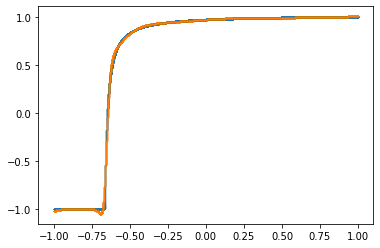

In [58]:
plt.scatter(x_scld_np,y_scld_np,s=0.01)
plt.scatter(x_scld_np,y_scld_pred_np,s=0.01)

In [60]:
mlp(torch.Tensor([2]))

tensor([1.0509], grad_fn=<AddBackward0>)